In [1]:
import os
import subprocess
import sys
sys.path.insert(1, os.path.abspath('../tools'))
import time
import numpy as np
from scipy.interpolate import interp1d
import zipfile
import pylhe
from scipy.interpolate import make_interp_spline
from AnalysisMG5 import Analysis
from decayChainAnalytic import getAvgGammaBeta
from decayChainAnalytic import getDecayGammaBeta
from decayChainAnalytic import velocity
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import json 
import seaborn as sns

#plotting options
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution
plt.rcParams['figure.figsize'] = (10,8)


#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=2.0)
cm = plt.cm.get_cmap('RdYlBu')

### Define labels for distinct processes

In [3]:

processLatexLabels = {'gluino_2body' : r'$pp \to \tilde g + \tilde g, \tilde g \to \tilde u u$',
                'chargino_2bodyE' : r'$pp \to \tilde \chi_1^+ + \tilde \chi_1^-, \tilde \chi_1^\pm \to \tilde e^\pm \nu$',
                'selectron_2body' : r'$pp \to \tilde e^+ + \tilde e^-, \tilde e^\pm \to \tilde \chi_1^0 e^\pm$',
                'gluino_3body' : r'$pp \to \tilde g + \tilde g, \tilde g \to \tilde \chi_1^0 u u$',
                'squark_2body' : r'$pp \to \tilde u + \tilde u, \tilde y \to \tilde \chi_1^0 u$',
                'chargino_2bodyW' : r'$pp \to \tilde \chi_1^+ + \tilde \chi_1^-, \tilde \chi_1^\pm \to \tilde \chi_1^0 W^\pm$',
                'gluino_2step' : r'$pp \to \tilde g + \tilde g, \tilde g \to \tilde u u, \tilde u \to \tilde \chi_1^0 u$',
                'higgs_2step' : r'$pp \to H^+ + H^-, H^\pm \to H^0 W^\pm, H^0 \to h Z$'}

processShortLabels = {'GammaBeta_2C_n30000.dat' : 'gluino_2body',
                'GammaBeta_spinhalf_n20000.dat' : 'chargino_2bodyE',
                'GammaBeta_spin0_Analise.dat' : 'selectron_2body',
                'GammaBeta_3C_Analise.dat' : 'gluino_3body',
                'GammaBeta_T-chanel_n10000.dat' : 'squark_2body',
                'GammaBeta_spinmeioW_n20000.dat' : 'chargino_2bodyW',
                'GammaBeta_3D_Go_n30000.dat' : 'gluino_2step',
                'GammaBeta_3D_H_n40000.dat' : 'higgs_2step'}

processBetaLabels = {'GammaBeta_2C_n30000.dat' : 'VGO',
                'GammaBeta_spinhalf_n20000.dat' : 'VX',
                'GammaBeta_spin0_Analise.dat' : 'VER',
                'GammaBeta_3C_Analise.dat' : 'VGO',
                'GammaBeta_T-chanel_n10000.dat' : 'VUR',
                'GammaBeta_spinmeioW_n20000.dat' : 'VX',
                'GammaBeta_3D_Go_n30000.dat' : 'VGO',
                'GammaBeta_3D_H_n40000.dat' : 'VH'}

In [4]:
# File paths containing the MadGraph output
dataDir = './validation_data'
madGraphOutput = 'GammaBeta_2C_n30000.dat' #2-body
# madGraphOutput = 'GammaBeta_spinhalf_n20000.dat' # Spin 1/2
# madGraphOutput = 'GammaBeta_spin0_Analise.dat' # Spin 0
# madGraphOutput = 'GammaBeta_3C_Analise.dat' # 3_Corpos  
# madGraphOutput = 'GammaBeta_T-chanel_n10000.dat' # T-Chanel  
# madGraphOutput = 'GammaBeta_spinmeioW_n20000.dat' # Massive SM Particule  
# madGraphOutput = 'GammaBeta_3D_Go_n30000.dat' # 2-steps Decay  
# madGraphOutput = 'GammaBeta_3D_H_n40000.dat' # 2-steps Decay Massive SM Particule  

## Fetch GammaBetas and Masses from file for each decay step

In [5]:
# Load gamma betas
GB=fromFile(os.path.join(dataDir,madGraphOutput))
GammaBetas = {'gb_%i' %i : GB[:,0,i] for i in range(GB.shape[2])}
# Compute Betas
Betas = {label.replace('gb','b') : gb/np.sqrt(1+gb**2) for label,gb in GammaBetas.items()}

## Compute boosts using the analytical approximation:

In [6]:
GammaBetasAna = {label : [] for label in GammaBetas}
Masses = []
timeList = []
smMass = [0.] 
# option for defining the hard collision average boost:
# VANA = analytical interpolation
# VGO = gluino pair-production
# VUR = squark pair-production
# VER = selectron pair-production
# VX = chargino pair-production
# VH = charged Higgs pair-production

# hardProcess = processBetaLabels[madGraphOutput]
hardProcess = 'VANA' 

t0 = time.time()
MXList = np.arange(300,4051,60)
for MX in MXList:
    M1list = np.linspace(100,(MX-10),6)
    for M1 in M1list:
        smMass = [0.,0.] # List of SM masses for each decay step (the first entry must be zero always
#         smMass = [0.,(MX-M1)/2] # List of SM masses for each decay step (3-body case)

        bsmMass = [MX,M1]
        massList = list(zip(bsmMass,smMass))
        
        GBana = getAvgGammaBeta(Ms=massList,beta0Process=hardProcess,computeStd=False)
        GBana = GBana[:,0] # Get only the gamma*beta values (remove std)
        for i,gb in enumerate(GBana):
            label = 'gb_%i' %i
            GammaBetasAna[label].append(gb)
        Masses.append(massList)
print('Done in %1.2f s' %(time.time()-t0))

Done in 0.03 s


In [7]:
# Convert lists to numpy arrays
GammaBetasAna = {label : np.array(gbs) for label,gbs in GammaBetasAna.items()}
Masses = np.array(Masses)

In [8]:
# Compute betas:
BetasAna = {label.replace('gb','b') : gb/np.sqrt(1+gb**2) for label,gb in GammaBetasAna.items()}

## Plot Results

### First Decay

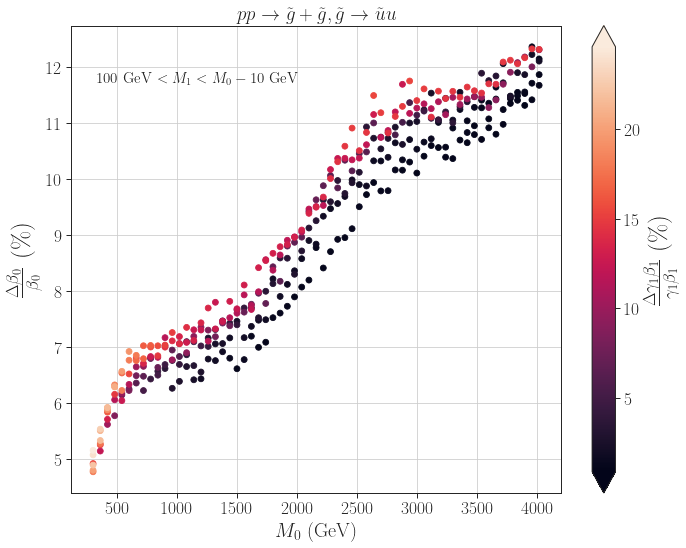

In [9]:
x = Masses[:,0,0] # M0
y = 100*(BetasAna['b_0']-Betas['b_0'])/Betas['b_0']
z = 100*np.abs(GammaBetasAna['gb_1']-GammaBetas['gb_1'])/GammaBetas['gb_1']

xlabel = r'$M_0$ (GeV)'
ylabel = r'$\frac{\Delta \beta_0}{\beta_0}$ (\%)'
zlabel = r'$\frac{\Delta \gamma_1 \beta_1}{\gamma_1 \beta_1}$ (\%)'
title = processLatexLabels[processShortLabels[madGraphOutput]]
text = r'100 GeV $< M_1 < M_0 - 10$ GeV'

plt.scatter(x,y,c=z,s=35)
cb = plt.colorbar(extend='both')
cb.set_label(label=zlabel,fontsize=25)
plt.xlabel(xlabel,fontsize=20)
plt.ylabel(ylabel,fontsize=25)
plt.title(title)
plt.text(1.1*min(x),0.95*max(y),text,fontsize=15)

plt.grid(True)
plt.tight_layout()
figname = processShortLabels[madGraphOutput]+'.png'

ff = plt.savefig(figname, format='png')
plt.show()

### Second Decay (if available)

In [10]:
if len(GammaBetas) > 2:
    x = Masses[:,1,0] # M1
    y = 100*(BetasAna['b_1']-Betas['b_1'])/Betas['b_1']
    z = 100*np.abs(GammaBetasAna['gb_2']-GammaBetas['gb_2'])/GammaBetas['gb_2']

    xlabel = r'$M_1$ (GeV)'
    ylabel = r'$\frac{\Delta \beta_1}{\beta_1}$ (\%)'
    zlabel = r'$\frac{\Delta \gamma_2 \beta_2}{\gamma_2 \beta_2}$ (\%)'
    title = processLatexLabels[processShortLabels[madGraphOutput]]
    text = r'100 GeV $< M_1 < M_0 - 10$ GeV'

    plt.scatter(x,y,c=z,s=35)
    cb = plt.colorbar(extend='both')
    cb.set_label(label=zlabel,fontsize=25)
    plt.xlabel(xlabel,fontsize=20)
    plt.ylabel(ylabel,fontsize=25)
    plt.title(title)
    plt.text(1.1*min(x),0.95*max(y),text,fontsize=15)

    plt.grid(True)
    plt.tight_layout()
    figname = processShortLabels[madGraphOutput]+'_2ndDecay.png'

    ff = plt.savefig(figname, format='png')
    plt.show()